In [13]:
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from scipy import fft
from scipy.ndimage import gaussian_filter
from skimage.feature import peak_local_max
from skimage import img_as_float
from skimage.exposure import histogram
from skimage.transform import warp
from skimage.util import random_noise

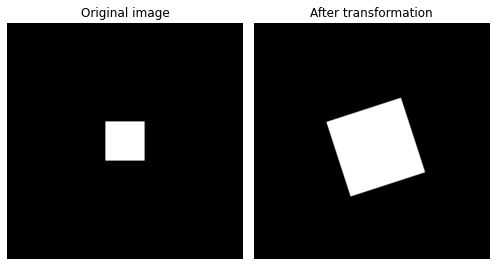

In [16]:
# 2.2
def scale(s):
    return np.matrix([[s,0,0],[0,s,0],[0,0,1]])

def rotate(theta):
    return np.matrix([[np.cos(theta),np.sin(theta),0],
                      [-np.sin(theta),np.cos(theta),0],
                      [0,0,1]])
     
def translate(t):
    return np.matrix([[1,0,t[0]],[0,1,t[1]],[0,0,1]])   

def transformation(img, s, theta, t):
    x,y = img.shape
    Tt = translate(t)
    Tc = translate([x/2, y/2])
    R = rotate(theta)
    S = scale(s)
    transform_matrix = Tt @ Tc @ R @ S @ np.linalg.inv(Tc)
    return warp(img, np.linalg.inv(transform_matrix))

image = np.pad(np.ones([100,100]), ((251,251),(251,251)))
image1 =transformation(image, 2, np.pi/10, [10.4,15.7])

fig, ax = plt.subplots(1, 2, figsize=(7, 4))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original image')
ax[0].axis('off')
ax[1].imshow(image1, cmap='gray')
ax[1].set_title('After transformation')
ax[1].axis('off')
plt.tight_layout()

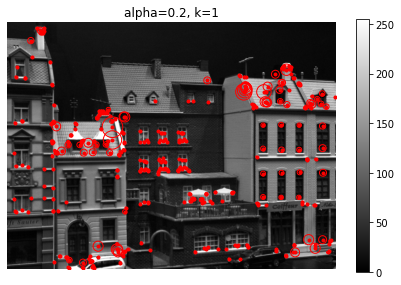

In [22]:
# 3.1
def R(img, k, sigma, alpha):
    lx = gaussian_filter(img, sigma, order=(0,1))
    ly = gaussian_filter(img, sigma, order=(1,0))
    glxx = gaussian_filter(lx**2, k*sigma)
    glyy = gaussian_filter(ly**2, k*sigma)
    glxy = gaussian_filter(lx*ly, k*sigma)
    return sigma**4*((glxx*glyy-glxy*glxy)-alpha*(glxx + glyy)**2)

def find_corner_harris(img, k, sigma, alpha, num_peaks=350):
    img = img_as_float(img)
    scale_space = np.array([R(img, k, s, alpha) for s in sigma])
    return peak_local_max(scale_space, num_peaks=num_peaks)

scale_levels=30
sigma=np.logspace(0, 5, scale_levels, base=2)
modelhouses = imread('modelhouses.png', as_gray=True)

fig, ax = plt.subplots(figsize=(6, 4))
im = ax.imshow(modelhouses, cmap="gray")
coor = find_corner_harris(modelhouses, 1, sigma, alpha=0.2)
ax.plot(coor[:, 2], coor[:, 1], 'r.')
x,y = coor.shape
for i in range(x):
    circle = plt.Circle((coor[i, 2], coor[i, 1]), 
                    sigma[coor[i, 0]],
                    color='r',
                    fill = False)
    ax.add_artist(circle)
fig.colorbar(im)
ax.set_axis_off()
ax.set_title('alpha=0.2, k=1')
plt.tight_layout()

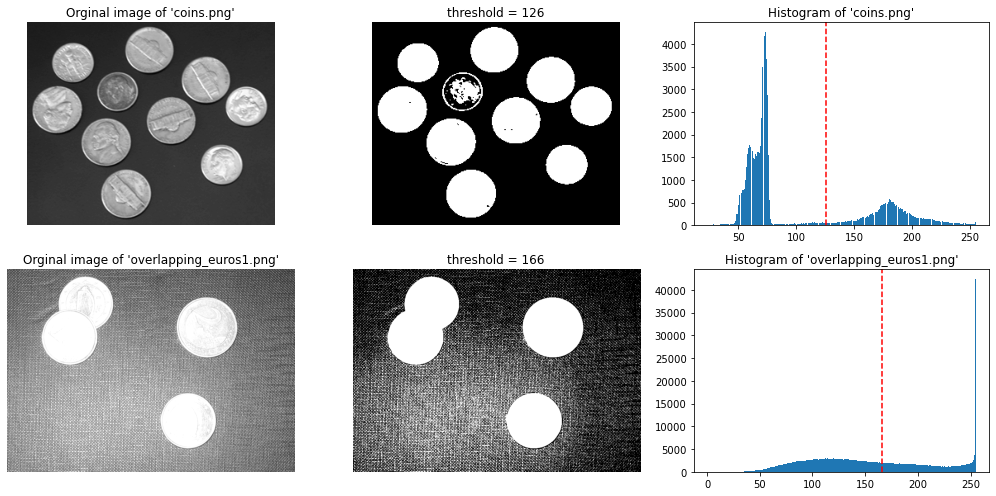

In [39]:
# 4.3
def find_threshold(image, bins=256):
    hist, bin_centers = histogram(image, bins)
    w1 = np.cumsum(hist)
    w2 = np.cumsum(hist[::-1])[::-1]
    mean_1 = np.cumsum(hist * bin_centers) / w1
    mean_2 = (np.cumsum((hist * bin_centers)[::-1]) / w2[::-1])[::-1]
    variance = w1[:-1] * w2[1:] * (mean_1[:-1] - mean_2[1:]) ** 2
    return bin_centers[np.argmax(variance)]

coins = imread('coins.png')
threshold_coins = find_threshold(coins)
euros = imread('overlapping_euros1.png')
threshold_euros = find_threshold(euros)

fig, ax = plt.subplots(2, 3, figsize = (14,7))
ax[0, 0].imshow(coins, cmap = 'gray')
ax[0, 0].axis('off')
ax[0, 0].set_title('Orginal image of \'coins.png\'')
ax[0, 1].imshow(coins > threshold_coins, cmap = 'gray')
ax[0, 1].axis('off')
ax[0, 1].set_title('threshold = {}'.format(threshold_coins))
ax[0, 2].hist(coins.flatten(), 256)
ax[0, 2].axvline(threshold_coins, color='red', ls='--')
ax[0, 2].set_title('Histogram of \'coins.png\'')
ax[1, 0].imshow(euros, cmap = 'gray')
ax[1, 0].axis('off')
ax[1, 0].set_title('Orginal image of \'overlapping_euros1.png\'')
ax[1, 1].imshow(euros > threshold_euros, cmap = 'gray')
ax[1, 1].axis('off')
ax[1, 1].set_title('threshold = {}'.format(threshold_euros))
ax[1, 2].hist(euros.flatten(), 256)
ax[1, 2].axvline(threshold_euros, color='red', ls='--')
ax[1, 2].set_title('Histogram of \'overlapping_euros1.png\'')
plt.tight_layout()

Text(0.5, 1.0, 'Simple intensity-based segmentation')

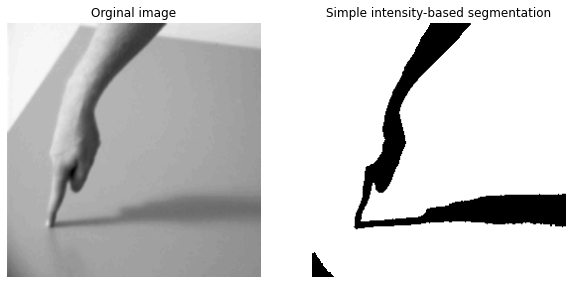

In [ ]:
# 4.1
coins = imread('hand.tiff', as_gray=True)
# plt.hist(coins.flatten(),256)
# plt.show()

fig, ax = plt.subplots(1, 2, figsize = (10,6))
threshold_coins = find_threshold(coins)
ax[0].imshow(coins, cmap = 'gray')
ax[0].axis('off')
ax[0].set_title('Orginal image')
ax[1].imshow(coins > threshold_coins, cmap = 'gray')
ax[1].axis('off')
ax[1].set_title('Simple intensity-based segmentation')

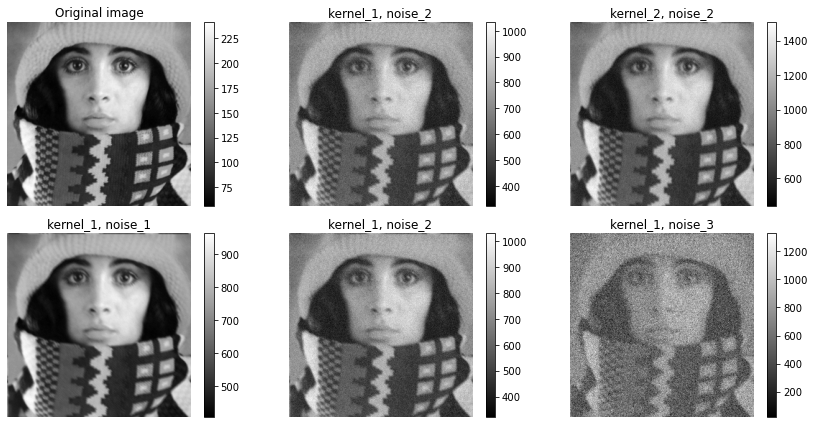

In [4]:
# 5.1
def image_degradation_process(img, kernel, noise):
    H = fft.fft2(kernel, img.shape)
    F = fft.fft2(img)
    N = fft.fft2(noise, img.shape)
    G = H * F + N
    result = fft.ifft2(G)
    return result

trui = imread('trui.png')

noise_1 = np.random.normal(1, 0.01, trui.shape) * np.max(trui)
noise_2 = np.random.normal(1, 0.1, trui.shape) * np.max(trui)
noise_3 = np.random.normal(1, 0.5, trui.shape) * np.max(trui)
kernel_1 = np.diag(np.ones(3))
kernel_2 = np.array([[1,1,0],
                     [0,1,0],
                     [0,1,1]])

trui_1 = np.abs(image_degradation_process(trui, kernel_1, noise_1))
trui_2 = np.abs(image_degradation_process(trui, kernel_1, noise_2))
trui_3 = np.abs(image_degradation_process(trui, kernel_1, noise_3))
trui_4 = np.abs(image_degradation_process(trui, kernel_1, noise_2))
trui_5 = np.abs(image_degradation_process(trui, kernel_2, noise_2))

fig, ax = plt.subplots(2, 3, figsize=(12,6))
im = ax[0, 0].imshow(trui, cmap='gray')
ax[0,0].set_title('Original image')
ax[0,0].axis('off')
plt.colorbar(im, ax=ax[0, 0])
im = ax[0, 1].imshow(trui_4, cmap='gray')
ax[0,1].set_title('kernel_1, noise_2')
ax[0,1].axis('off')
plt.colorbar(im, ax=ax[0, 1])
im = ax[0, 2].imshow(trui_5, cmap='gray')
ax[0,2].set_title('kernel_2, noise_2')
ax[0,2].axis('off')
plt.colorbar(im, ax=ax[0, 2])
im = ax[1, 0].imshow(trui_1, cmap='gray')
ax[1,0].set_title('kernel_1, noise_1')
ax[1,0].axis('off')
plt.colorbar(im, ax=ax[1, 0])
im = ax[1, 1].imshow(trui_2, cmap='gray')
ax[1,1].set_title('kernel_1, noise_2')
ax[1,1].axis('off')
plt.colorbar(im, ax=ax[1, 1])
im = ax[1, 2].imshow(trui_3, cmap='gray')
ax[1,2].set_title('kernel_1, noise_3')
ax[1,2].axis('off')
plt.colorbar(im, ax=ax[1, 2])
plt.tight_layout()
plt.show()

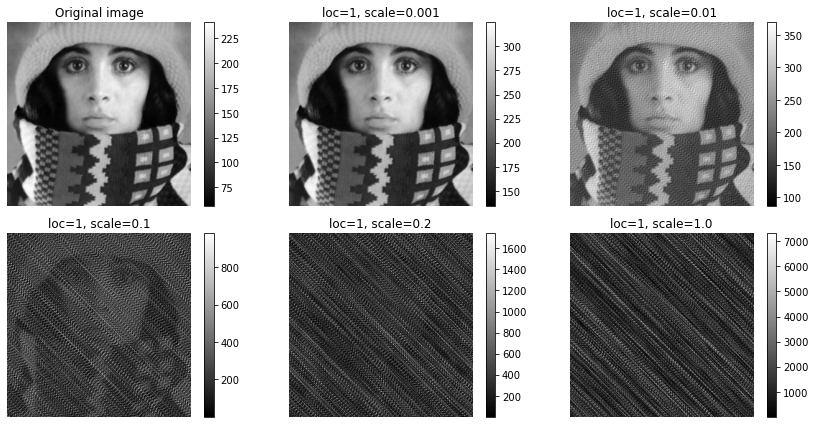

In [224]:
# 5.2
def direct_inverse_filter(img, kernel):
    H = fft.fft2(kernel, img.shape)
    G = fft.fft2(img)
    F_tilde = G / H
    return fft.ifft2(F_tilde)

noise_1 = np.random.normal(1, 0.001, trui.shape) * np.max(trui)
noise_2 = np.random.normal(1, 0.01, trui.shape) * np.max(trui)
noise_3 = np.random.normal(1, 0.1, trui.shape) * np.max(trui)
noise_4 = np.random.normal(1, 0.2, trui.shape) * np.max(trui)
noise_5 = np.random.normal(1, 1.0, trui.shape) * np.max(trui)
kernel = np.diag(np.ones(3))

trui_1 = np.abs(image_degradation_process(trui, kernel, noise_1))
trui_2 = np.abs(image_degradation_process(trui, kernel, noise_2))
trui_3 = np.abs(image_degradation_process(trui, kernel, noise_3))
trui_4 = np.abs(image_degradation_process(trui, kernel, noise_4))
trui_5 = np.abs(image_degradation_process(trui, kernel, noise_5))
trui_11 = np.abs(direct_inverse_filter(trui_1, kernel))
trui_22 = np.abs(direct_inverse_filter(trui_2, kernel))
trui_33 = np.abs(direct_inverse_filter(trui_3, kernel))
trui_44 = np.abs(direct_inverse_filter(trui_4, kernel))
trui_55 = np.abs(direct_inverse_filter(trui_5, kernel))


fig, ax = plt.subplots(2, 3, figsize=(12,6))
im = ax[0, 0].imshow(trui, cmap='gray')
ax[0,0].set_title('Original image')
ax[0,0].axis('off')
plt.colorbar(im, ax=ax[0, 0])
im = ax[0, 1].imshow(trui_11, cmap='gray')
ax[0,1].set_title('loc=1, scale=0.001')
ax[0,1].axis('off')
plt.colorbar(im, ax=ax[0, 1])
im = ax[0, 2].imshow(trui_22, cmap='gray')
ax[0,2].set_title('loc=1, scale=0.01')
ax[0,2].axis('off')
plt.colorbar(im, ax=ax[0, 2])
im = ax[1, 0].imshow(trui_33, cmap='gray')
ax[1,0].set_title('loc=1, scale=0.1')
ax[1,0].axis('off')
plt.colorbar(im, ax=ax[1, 0])
im = ax[1, 1].imshow(trui_44, cmap='gray')
ax[1,1].set_title('loc=1, scale=0.2')
ax[1,1].axis('off')
plt.colorbar(im, ax=ax[1, 1])
im = ax[1, 2].imshow(trui_55, cmap='gray')
ax[1,2].set_title('loc=1, scale=1.0')
ax[1,2].axis('off')
plt.colorbar(im, ax=ax[1, 2])
plt.tight_layout()
plt.show()

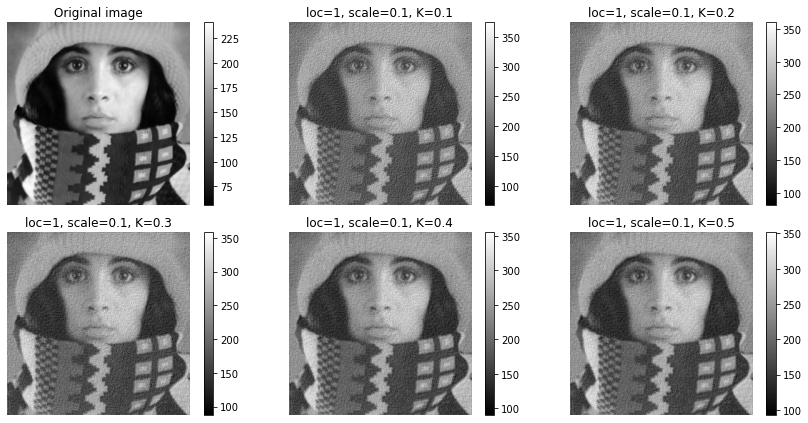

In [232]:
# 5.3
def wiener(img, kernel, K):
    H = fft.fft2(kernel, img.shape)
    G = fft.fft2(img)
    H2 = H * np.conj(H)
    H_prime_i = H2/(H*H2+K)
    return fft.ifft2(G*H_prime_i)

noise_k = np.random.normal(1, 0.1, trui.shape) * np.max(trui)
kernel = np.diag(np.ones(3))
i = np.abs(image_degradation_process(trui, kernel, noise_k))
trui_11 = np.abs(wiener(i, kernel, 0.1))
trui_22 = np.abs(wiener(i, kernel, 0.2))
trui_33 = np.abs(wiener(i, kernel, 0.3))
trui_44 = np.abs(wiener(i, kernel, 0.4))
trui_55 = np.abs(wiener(i, kernel, 0.5))


fig, ax = plt.subplots(2, 3, figsize=(12,6))
im = ax[0, 0].imshow(trui, cmap='gray')
ax[0,0].set_title('Original image')
ax[0,0].axis('off')
plt.colorbar(im, ax=ax[0, 0])
im = ax[0, 1].imshow(trui_11, cmap='gray')
ax[0,1].set_title('loc=1, scale=0.1, K=0.1')
ax[0,1].axis('off')
plt.colorbar(im, ax=ax[0, 1])
im = ax[0, 2].imshow(trui_22, cmap='gray')
ax[0,2].set_title('loc=1, scale=0.1, K=0.2')
ax[0,2].axis('off')
plt.colorbar(im, ax=ax[0, 2])
im = ax[1, 0].imshow(trui_33, cmap='gray')
ax[1,0].set_title('loc=1, scale=0.1, K=0.3')
ax[1,0].axis('off')
plt.colorbar(im, ax=ax[1, 0])
im = ax[1, 1].imshow(trui_44, cmap='gray')
ax[1,1].set_title('loc=1, scale=0.1, K=0.4')
ax[1,1].axis('off')
plt.colorbar(im, ax=ax[1, 1])
im = ax[1, 2].imshow(trui_55, cmap='gray')
ax[1,2].set_title('loc=1, scale=0.1, K=0.5')
ax[1,2].axis('off')
plt.colorbar(im, ax=ax[1, 2])
plt.tight_layout()
plt.show()